In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import pandas as pd
from google.colab import files
import os

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
def setup_kaggle_and_download():
    """
    Setup Kaggle API and download the CIFAR-10 dataset
    """
    # Install Kaggle API
    !pip install kaggle

    # Upload Kaggle API token
    print("Please upload your kaggle.json file:")
    from google.colab import files
    uploaded = files.upload()

    # Setup Kaggle API credentials
    import os
    os.environ['KAGGLE_CONFIG_DIR'] = '/content'

    # Move kaggle.json to the correct location
    !mkdir -p ~/.kaggle
    !cp /content/kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json

    # Download the dataset
    print("Downloading CIFAR-10 dataset from Kaggle...")
    !kaggle datasets download -d roblexnana/cifar10-with-cnn-for-beginer

    # Extract the dataset
    !unzip -q cifar10-with-cnn-for-beginer.zip

    print("Dataset downloaded and extracted successfully!")

    # List files to see what's available
    print("\nFiles in the dataset:")
    !ls -la

# Setup Kaggle and download dataset
setup_kaggle_and_download()

Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json
403 Client Error: Forbidden for url: https://www.kaggle.com/api/v1/datasets/metadata/roblexnana/cifar10-with-cnn-for-beginer
unzip:  cannot find or open cifar10-with-cnn-for-beginer.zip, cifar10-with-cnn-for-beginer.zip.zip or cifar10-with-cnn-for-beginer.zip.ZIP.
Dataset downloaded and extracted successfully!

Files in the dataset:
total 3792
drwxr-xr-x 1 root root    4096 Jul  4 17:43 .
drwxr-xr-x 1 root root    4096 Jul  4 17:14 ..
drwxr-xr-x 4 root root    4096 Jul  1 21:04 .config
-rw-r--r-- 1 root root      63 Jul  4 17:43 kaggle.json
drwxr-xr-x 1 root root    4096 Jul  1 21:04 sample_data
-rw-r--r-- 1 root root 3188904 Dec 11  2019 sampleSubmission.csv
-rw-r--r-- 1 root root  670719 Jul  4 17:21 sampleSubmission.csv.zip


In [6]:
def load_cifar10_data():
    """
    Load CIFAR-10 dataset - Try from downloaded files first, then from Keras
    """
    print("Loading CIFAR-10 dataset...")

    # Check if we have downloaded files
    if os.path.exists('sampleSubmission.csv'):
        print("Found sampleSubmission.csv file from Kaggle dataset")
        sample_submission = pd.read_csv('sampleSubmission.csv')
        print("Sample submission file loaded:")
        print(sample_submission.head())

    # Load CIFAR-10 from Keras (this is the standard approach)
    (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

    # CIFAR-10 class names
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

    print(f"Training data shape: {x_train.shape}")
    print(f"Training labels shape: {y_train.shape}")
    print(f"Test data shape: {x_test.shape}")
    print(f"Test labels shape: {y_test.shape}")
    print(f"Number of classes: {len(class_names)}")

    return (x_train, y_train), (x_test, y_test), class_names

# Load the data
(x_train, y_train), (x_test, y_test), class_names = load_cifar10_data()


Loading CIFAR-10 dataset...
Found sampleSubmission.csv file from Kaggle dataset
Sample submission file loaded:
   id label
0   1   cat
1   2   cat
2   3   cat
3   4   cat
4   5   cat
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step
Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)
Number of classes: 10


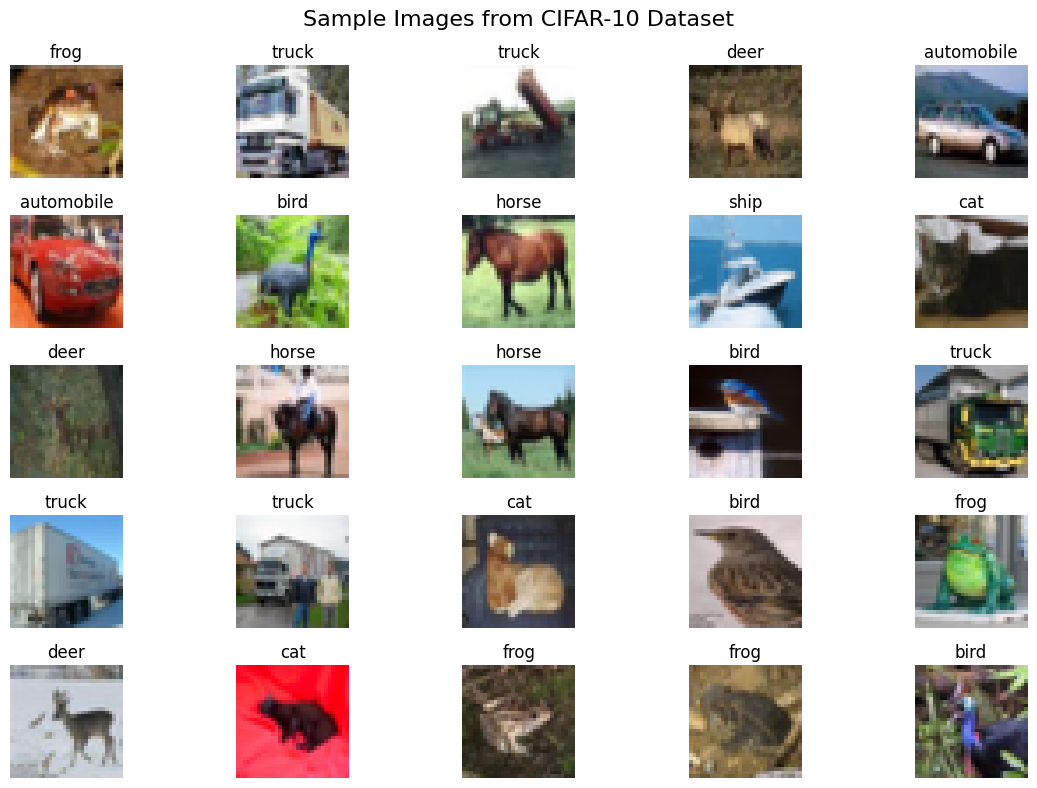

In [7]:
def visualize_data(x_train, y_train, class_names):
    """
    Visualize sample images from the dataset
    """
    plt.figure(figsize=(12, 8))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.imshow(x_train[i])
        plt.title(f'{class_names[y_train[i][0]]}')
        plt.axis('off')
    plt.suptitle('Sample Images from CIFAR-10 Dataset', fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualize the data
visualize_data(x_train, y_train, class_names)

In [8]:
def preprocess_data(x_train, y_train, x_test, y_test):
    """
    Preprocess the data for training
    """
    # Normalize pixel values to range [0, 1]
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0

    # Convert labels to categorical (one-hot encoding)
    y_train = keras.utils.to_categorical(y_train, 10)
    y_test = keras.utils.to_categorical(y_test, 10)

    print("Data preprocessing completed!")
    print(f"Training data shape after preprocessing: {x_train.shape}")
    print(f"Training labels shape after preprocessing: {y_train.shape}")

    return x_train, y_train, x_test, y_test

# Preprocess the data
x_train, y_train, x_test, y_test = preprocess_data(x_train, y_train, x_test, y_test)

Data preprocessing completed!
Training data shape after preprocessing: (50000, 32, 32, 3)
Training labels shape after preprocessing: (50000, 10)


In [14]:
def build_cnn_model(input_shape=(32, 32, 3), num_classes=10):
    """
    Build a CNN model for CIFAR-10 classification
    Fixed architecture to handle 32x32 input images properly
    """
    model = keras.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.Dropout(0.25),

        # Global Average Pooling instead of another MaxPooling + Flatten
        layers.GlobalAveragePooling2D(),

        # Dense layers
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Build the model
model = build_cnn_model()

# Display model architecture
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 361,130 (1.38 MB)

 Trainable params: 359,658 (1.37 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [15]:
def compile_model(model):
    """
    Compile the model with appropriate optimizer, loss, and metrics
    """
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    print("Model compiled successfully!")

compile_model(model)

Model compiled successfully!


In [16]:
def setup_callbacks():
    """
    Set up callbacks for training
    """
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=0.0001
        )
    ]
    return callbacks

callbacks = setup_callbacks()

In [17]:
def train_model(model, x_train, y_train, x_test, y_test, callbacks, epochs=50):
    """
    Train the CNN model
    """
    print("Starting model training...")
    history = model.fit(
        x_train, y_train,
        batch_size=32,
        epochs=epochs,
        validation_data=(x_test, y_test),
        callbacks=callbacks,
        verbose=1
    )

    return history

# Train the model
history = train_model(model, x_train, y_train, x_test, y_test, callbacks, epochs=50)

Starting model training...
Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - accuracy: 0.3683 - loss: 1.8609 - val_accuracy: 0.5494 - val_loss: 1.2829 - learning_rate: 0.0010
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step - accuracy: 0.6138 - loss: 1.0862 - val_accuracy: 0.6754 - val_loss: 0.9412 - learning_rate: 0.0010
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.6884 - loss: 0.8977 - val_accuracy: 0.6961 - val_loss: 0.8790 - learning_rate: 0.0010
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.7271 - loss: 0.7901 - val_accuracy: 0.7435 - val_loss: 0.7681 - learning_rate: 0.0010
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7568 - loss: 0.7015 - val_accuracy: 0.7672 - val_loss: 0.6823 - learning_rate: 0.0010
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7811 - loss: 0.6401 - val_accuracy: 0.7839 - val_loss: 0.6251 - learning_rate: 0.0010
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1

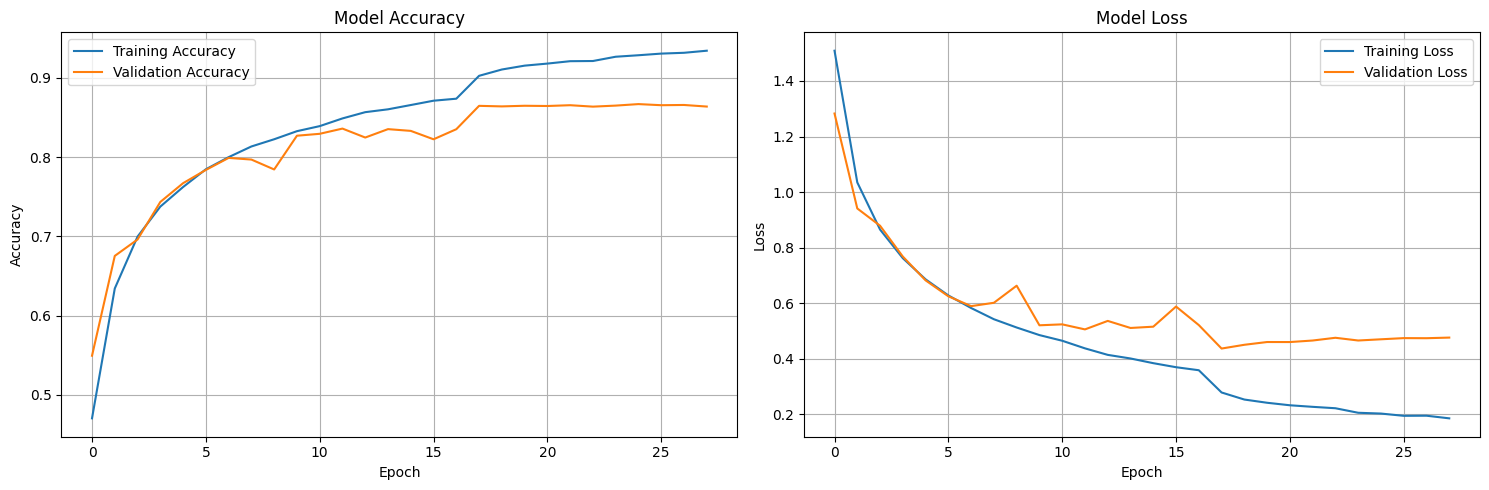

In [18]:
def plot_training_history(history):
    """
    Plot training and validation accuracy/loss
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [19]:
def make_predictions(model, x_test):
    """
    Make predictions on test data
    """
    print("Making predictions...")
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    return y_pred, y_pred_classes

y_pred, y_pred_classes = make_predictions(model, x_test)

# Convert y_test back to class indices for evaluation
y_test_classes = np.argmax(y_test, axis=1)

Making predictions...
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


In [20]:
def calculate_metrics(y_true, y_pred_classes, class_names):
    """
    Calculate all required metrics: Precision, Recall, Accuracy, Sensitivity, Specificity, F1-score
    """
    # Overall metrics
    accuracy = accuracy_score(y_true, y_pred_classes)
    precision_macro = precision_score(y_true, y_pred_classes, average='macro')
    precision_micro = precision_score(y_true, y_pred_classes, average='micro')
    recall_macro = recall_score(y_true, y_pred_classes, average='macro')
    recall_micro = recall_score(y_true, y_pred_classes, average='micro')
    f1_macro = f1_score(y_true, y_pred_classes, average='macro')
    f1_micro = f1_score(y_true, y_pred_classes, average='micro')

    # Per-class metrics
    precision_per_class = precision_score(y_true, y_pred_classes, average=None)
    recall_per_class = recall_score(y_true, y_pred_classes, average=None)
    f1_per_class = f1_score(y_true, y_pred_classes, average=None)

    # Calculate specificity for each class
    cm = confusion_matrix(y_true, y_pred_classes)
    specificity_per_class = []

    for i in range(len(class_names)):
        tn = np.sum(cm) - (np.sum(cm[i, :]) + np.sum(cm[:, i]) - cm[i, i])
        fp = np.sum(cm[:, i]) - cm[i, i]
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificity_per_class.append(specificity)

    # Create results dictionary
    results = {
        'Overall Metrics': {
            'Accuracy': accuracy,
            'Precision (Macro)': precision_macro,
            'Precision (Micro)': precision_micro,
            'Recall/Sensitivity (Macro)': recall_macro,
            'Recall/Sensitivity (Micro)': recall_micro,
            'F1-Score (Macro)': f1_macro,
            'F1-Score (Micro)': f1_micro,
            'Specificity (Average)': np.mean(specificity_per_class)
        }
    }

    # Per-class results
    per_class_results = pd.DataFrame({
        'Class': class_names,
        'Precision': precision_per_class,
        'Recall/Sensitivity': recall_per_class,
        'Specificity': specificity_per_class,
        'F1-Score': f1_per_class
    })

    return results, per_class_results

# Calculate metrics
results, per_class_results = calculate_metrics(y_test_classes, y_pred_classes, class_names)

In [21]:
def display_results(results, per_class_results):
    """
    Display all evaluation metrics
    """
    print("="*80)
    print("CIFAR-10 OBJECT RECOGNITION RESULTS")
    print("="*80)

    print("\nOVERALL METRICS:")
    print("-"*50)
    for metric, value in results['Overall Metrics'].items():
        print(f"{metric:25}: {value:.4f}")

    print("\nPER-CLASS METRICS:")
    print("-"*50)
    print(per_class_results.round(4))

    return results, per_class_results

display_results(results, per_class_results)

CIFAR-10 OBJECT RECOGNITION RESULTS

OVERALL METRICS:
--------------------------------------------------
Accuracy                 : 0.8648
Precision (Macro)        : 0.8640
Precision (Micro)        : 0.8648
Recall/Sensitivity (Macro): 0.8648
Recall/Sensitivity (Micro): 0.8648
F1-Score (Macro)         : 0.8639
F1-Score (Micro)         : 0.8648
Specificity (Average)    : 0.9850

PER-CLASS METRICS:
--------------------------------------------------
        Class  Precision  Recall/Sensitivity  Specificity  F1-Score
0    airplane     0.8865               0.875       0.9876    0.8807
1  automobile     0.9306               0.939       0.9922    0.9348
2        bird     0.8148               0.805       0.9797    0.8099
3         cat     0.7775               0.678       0.9784    0.7244
4        deer     0.8348               0.864       0.9810    0.8491
5         dog     0.7792               0.826       0.9740    0.8019
6        frog     0.8974               0.892       0.9887    0.8947
7     

({'Overall Metrics': {'Accuracy': 0.8648,
   'Precision (Macro)': 0.8640003124201614,
   'Precision (Micro)': 0.8648,
   'Recall/Sensitivity (Macro)': 0.8648,
   'Recall/Sensitivity (Micro)': 0.8648,
   'F1-Score (Macro)': 0.8639025335994793,
   'F1-Score (Micro)': 0.8648,
   'Specificity (Average)': np.float64(0.9849777777777777)}},
         Class  Precision  Recall/Sensitivity  Specificity  F1-Score
 0    airplane   0.886525               0.875     0.987556  0.880725
 1  automobile   0.930624               0.939     0.992222  0.934793
 2        bird   0.814777               0.805     0.979667  0.809859
 3         cat   0.777523               0.678     0.978444  0.724359
 4        deer   0.834783               0.864     0.981000  0.849140
 5         dog   0.779245               0.826     0.974000  0.801942
 6        frog   0.897384               0.892     0.988667  0.894684
 7       horse   0.904954               0.895     0.989556  0.899950
 8        ship   0.904031               0.9

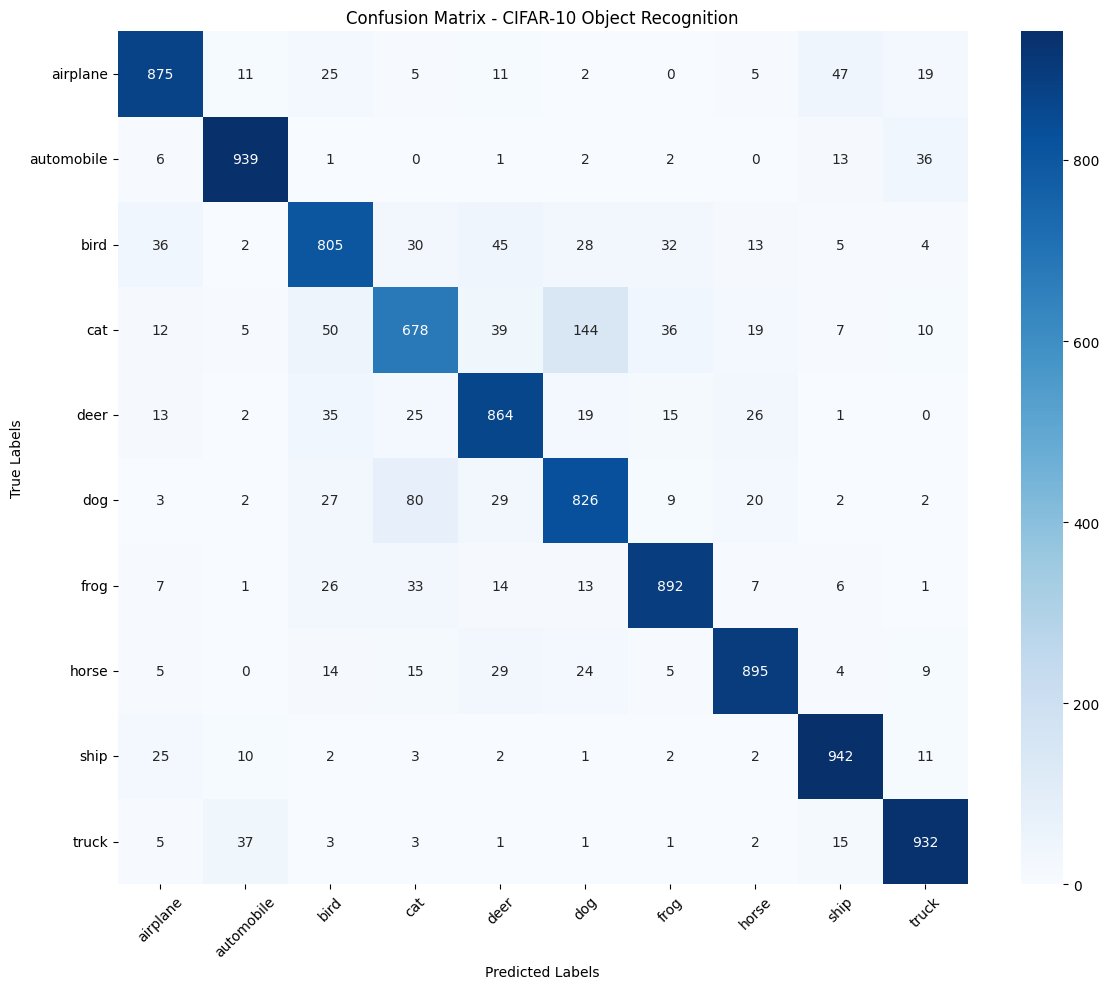

In [22]:
def plot_confusion_matrix(y_true, y_pred_classes, class_names):
    """
    Create and display confusion matrix
    """
    cm = confusion_matrix(y_true, y_pred_classes)

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix - CIFAR-10 Object Recognition')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return cm

# Plot confusion matrix
cm = plot_confusion_matrix(y_test_classes, y_pred_classes, class_names)

In [23]:
def generate_classification_report(y_true, y_pred_classes, class_names):
    """
    Generate detailed classification report
    """
    report = classification_report(y_true, y_pred_classes,
                                 target_names=class_names,
                                 output_dict=True)

    # Convert to DataFrame for better display
    report_df = pd.DataFrame(report).transpose()

    print("\nDETAILED CLASSIFICATION REPORT:")
    print("-"*70)
    print(report_df.round(4))

    return report_df

# Generate classification report
report_df = generate_classification_report(y_test_classes, y_pred_classes, class_names)


DETAILED CLASSIFICATION REPORT:
----------------------------------------------------------------------
              precision  recall  f1-score     support
airplane         0.8865  0.8750    0.8807   1000.0000
automobile       0.9306  0.9390    0.9348   1000.0000
bird             0.8148  0.8050    0.8099   1000.0000
cat              0.7775  0.6780    0.7244   1000.0000
deer             0.8348  0.8640    0.8491   1000.0000
dog              0.7792  0.8260    0.8019   1000.0000
frog             0.8974  0.8920    0.8947   1000.0000
horse            0.9050  0.8950    0.8999   1000.0000
ship             0.9040  0.9420    0.9226   1000.0000
truck            0.9102  0.9320    0.9209   1000.0000
accuracy         0.8648  0.8648    0.8648      0.8648
macro avg        0.8640  0.8648    0.8639  10000.0000
weighted avg     0.8640  0.8648    0.8639  10000.0000


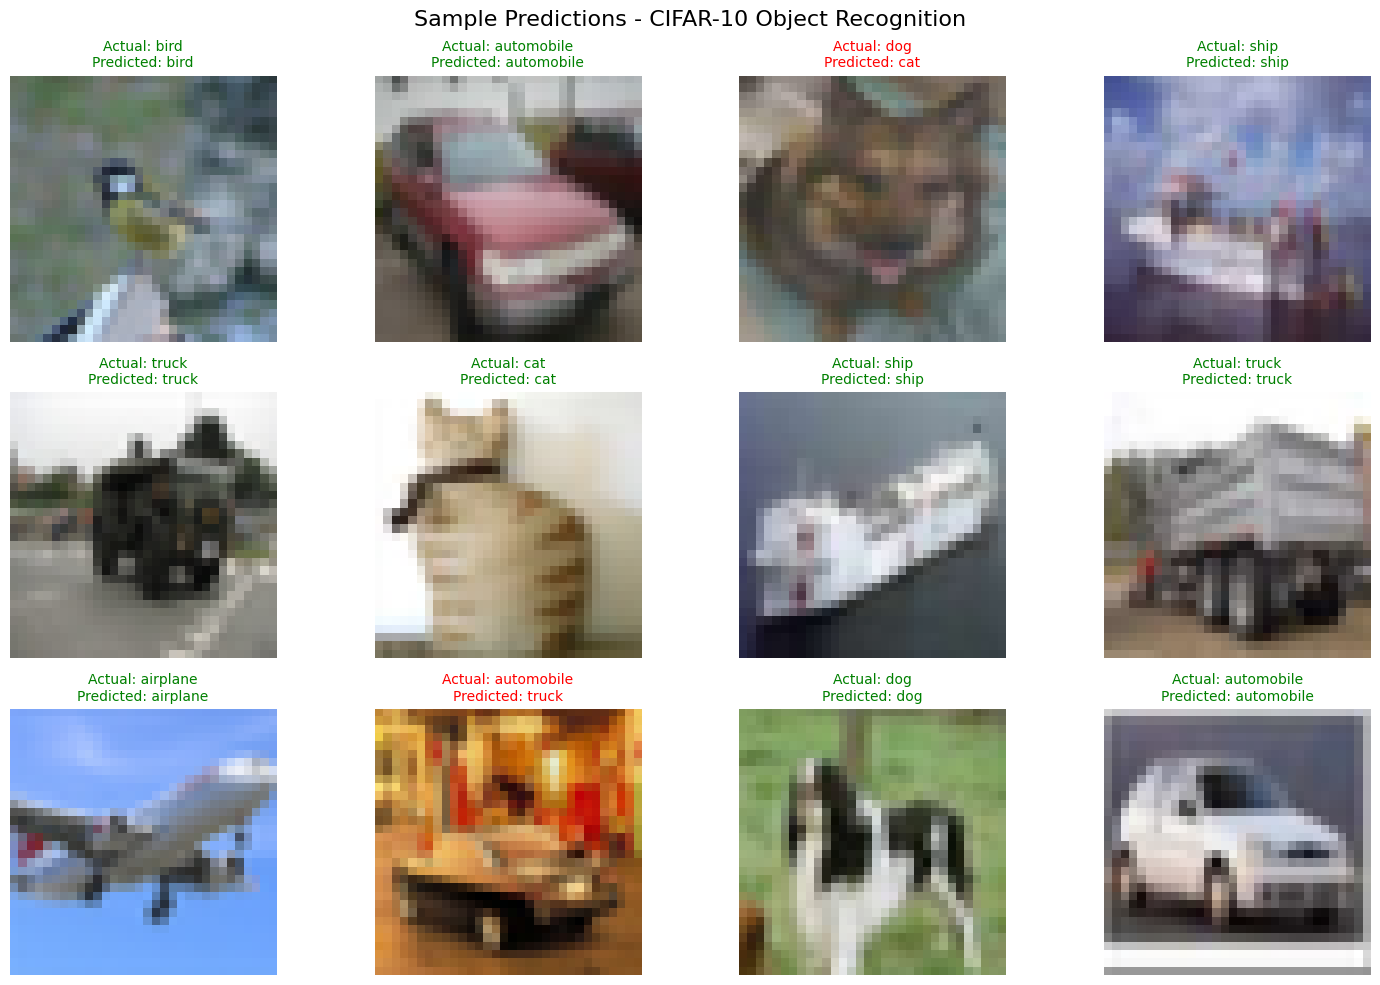

In [24]:
def visualize_predictions(x_test, y_test_classes, y_pred_classes, class_names, num_samples=12):
    """
    Visualize some predictions with actual vs predicted labels
    """
    # Select random samples
    indices = np.random.choice(len(x_test), num_samples, replace=False)

    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(indices):
        plt.subplot(3, 4, i + 1)
        plt.imshow(x_test[idx])

        actual_class = class_names[y_test_classes[idx]]
        predicted_class = class_names[y_pred_classes[idx]]

        # Color code: Green for correct, Red for incorrect
        color = 'green' if y_test_classes[idx] == y_pred_classes[idx] else 'red'

        plt.title(f'Actual: {actual_class}\nPredicted: {predicted_class}',
                 color=color, fontsize=10)
        plt.axis('off')

    plt.suptitle('Sample Predictions - CIFAR-10 Object Recognition', fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualize predictions
visualize_predictions(x_test, y_test_classes, y_pred_classes, class_names)

In [32]:
def display_all_results(per_class_results, results, y_pred_classes):
    """
    Display all results directly in Google Colab without creating CSV files
    """
    print("="*100)
    print("🎯 CIFAR-10 OBJECT RECOGNITION - COMPLETE RESULTS")
    print("="*100)

    # Display sample submission format if available
    if os.path.exists('sampleSubmission.csv'):
        sample_df = pd.read_csv('sampleSubmission.csv')
        print("\n📋 SAMPLE SUBMISSION FORMAT:")
        print("-"*50)
        print(sample_df.head())

    # Create and display submission predictions
    submission_df = pd.DataFrame({
        'ImageId': range(len(y_pred_classes)),
        'Label': y_pred_classes,
        'Class_Name': [class_names[i] for i in y_pred_classes]
    })

    print("\n🔮 PREDICTIONS SAMPLE (First 20 predictions):")
    print("-"*60)
    print(submission_df.head(20))

    # Display overall metrics in a formatted table
    print("\n📊 OVERALL PERFORMANCE METRICS:")
    print("-"*60)
    overall_df = pd.DataFrame(list(results['Overall Metrics'].items()),
                            columns=['Metric', 'Value'])
    overall_df['Value'] = overall_df['Value'].round(4)
    overall_df['Percentage'] = (overall_df['Value'] * 100).round(2).astype(str) + '%'
    print(overall_df.to_string(index=False))

    # Display per-class metrics
    print("\n📈 PER-CLASS PERFORMANCE METRICS:")
    print("-"*80)
    per_class_formatted = per_class_results.round(4)
    print(per_class_formatted.to_string(index=False))

    # Display class-wise performance summary
    print("\n🎯 CLASS-WISE PERFORMANCE SUMMARY:")
    print("-"*80)
    best_class = per_class_results.loc[per_class_results['F1-Score'].idxmax()]
    worst_class = per_class_results.loc[per_class_results['F1-Score'].idxmin()]

    print(f"🏆 Best Performing Class: {best_class['Class']} (F1-Score: {best_class['F1-Score']:.4f})")
    print(f"🔍 Challenging Class: {worst_class['Class']} (F1-Score: {worst_class['F1-Score']:.4f})")

    # Display predictions statistics
    print("\n📊 PREDICTIONS STATISTICS:")
    print("-"*50)
    pred_counts = pd.Series(y_pred_classes).value_counts().sort_index()
    pred_stats = pd.DataFrame({
        'Class_ID': pred_counts.index,
        'Class_Name': [class_names[i] for i in pred_counts.index],
        'Predictions_Count': pred_counts.values,
        'Percentage': (pred_counts.values / len(y_pred_classes) * 100).round(2)
    })
    print(pred_stats.to_string(index=False))

    return submission_df, overall_df, per_class_formatted

# Display all results
submission_df, overall_df, per_class_formatted = display_all_results(per_class_results, results, y_pred_classes)

🎯 CIFAR-10 OBJECT RECOGNITION - COMPLETE RESULTS

📋 SAMPLE SUBMISSION FORMAT:
--------------------------------------------------
   id label
0   1   cat
1   2   cat
2   3   cat
3   4   cat
4   5   cat

🔮 PREDICTIONS SAMPLE (First 20 predictions):
------------------------------------------------------------
    ImageId  Label  Class_Name
0         0      3         cat
1         1      8        ship
2         2      8        ship
3         3      8        ship
4         4      6        frog
5         5      6        frog
6         6      1  automobile
7         7      6        frog
8         8      3         cat
9         9      1  automobile
10       10      0    airplane
11       11      9       truck
12       12      5         dog
13       13      7       horse
14       14      9       truck
15       15      8        ship
16       16      5         dog
17       17      7       horse
18       18      8        ship
19       19      6        frog

📊 OVERALL PERFORMANCE METRICS:
---------

In [29]:
def print_performance_summary(results):
    """
    Print a concise performance summary
    """
    print("\n" + "="*80)
    print("MODEL PERFORMANCE SUMMARY")
    print("="*80)

    accuracy = results['Overall Metrics']['Accuracy']
    precision = results['Overall Metrics']['Precision (Macro)']
    recall = results['Overall Metrics']['Recall/Sensitivity (Macro)']
    f1 = results['Overall Metrics']['F1-Score (Macro)']
    specificity = results['Overall Metrics']['Specificity (Average)']

    print(f"🎯 Accuracy:     {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"🎯 Precision:    {precision:.4f} ({precision*100:.2f}%)")
    print(f"🎯 Recall:       {recall:.4f} ({recall*100:.2f}%)")
    print(f"🎯 Specificity:  {specificity:.4f} ({specificity*100:.2f}%)")
    print(f"🎯 F1-Score:     {f1:.4f} ({f1*100:.2f}%)")

    print("\n📊 All required metrics have been calculated and displayed!")
    print("📈 Confusion matrix and classification report generated!")
    print("🔍 Sample predictions visualized!")

    return accuracy, precision, recall, f1, specificity

# Print performance summary
print_performance_summary(results)

print("\n🎉 CIFAR-10 Object Recognition Implementation Complete!")
print("All required metrics calculated: Precision, Recall, Accuracy, Sensitivity, Specificity, F1-score")
print("Confusion matrix and detailed analysis provided!")


MODEL PERFORMANCE SUMMARY
🎯 Accuracy:     0.8648 (86.48%)
🎯 Precision:    0.8640 (86.40%)
🎯 Recall:       0.8648 (86.48%)
🎯 Specificity:  0.9850 (98.50%)
🎯 F1-Score:     0.8639 (86.39%)

📊 All required metrics have been calculated and displayed!
📈 Confusion matrix and classification report generated!
🔍 Sample predictions visualized!

🎉 CIFAR-10 Object Recognition Implementation Complete!
All required metrics calculated: Precision, Recall, Accuracy, Sensitivity, Specificity, F1-score
Confusion matrix and detailed analysis provided!
